In [26]:
import cv2
from skimage import transform
from skimage import exposure
from skimage import io
import numpy as np
from tensorflow.keras.models import load_model
import pandas as pd
from glob import glob
from collections import Counter
%matplotlib inline
from importlib import reload

In [2]:
# load model use full path
print("[INFO] loading model...")
model = load_model("sign_recognition_final_model/model.pb")

[INFO] loading model...


In [12]:
# load the label names
labelNames = open("images/signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

In [3]:
def process_images(path):
    # the function reads images, resizes and improves the contrast

    # read the image
    img = io.imread(path)

    # resize the image to be 32x32 pixels, ignoring aspect ratio
    img = transform.resize(img, (32,32))
    img = exposure.equalize_adapthist(img, clip_limit=0.1)
    
    # preprocess the image by scaling it to the range [0, 1]
    img = img.astype("float32") / 255.0
    # convert the data and labels to NumPy arrays
    image = np.expand_dims(img, axis=0)
        
    return image

In [8]:
def get_images(basePath, csvPath):
    # the function gets the paths & labels of test images
    
    # create empty lists to store image paths & labels
    images = []
    labels = []
    
    # open csv file and git rid of first row
    data = open(csvPath).read().split('\n')[1:]
    for d in data:
        if len(d.split(',')) > 1:

            # get the label of each image
            labels.append(d.split(',')[-2])
            # get the path of each image
            path = basePath + d.split(',')[-1]
            
            images.append(path)
        
    return images, labels

In [9]:
basePath = 'images/'
testPath = "images/Test.csv"
(testX, testY) = get_images(basePath, testPath)

In [14]:
# create empty lists to save predicted signs
predLabels = []
predValues = []

for path in testX:
    # load, resize,and process image
    image = process_images(path)
    
    # use model to predict image sign
    preds = model.predict(image)
    # get the maximum predicted value
    j = preds.argmax(axis=1)[0]
    
    # add sign value, and label
    predValues.append(j)
    predLabels.append(labelNames[j])

In [17]:
# create empty list to save false predicted images
error = []

for i in range(len(predValues)):
    if predValues[i] != int(testY[i]):
        error.append(i)
        
errorPath = [testX[i] for i in error]

In [39]:
errorLabels = [predLabels[i] for i in error]
countErrors = Counter(errorLabels)

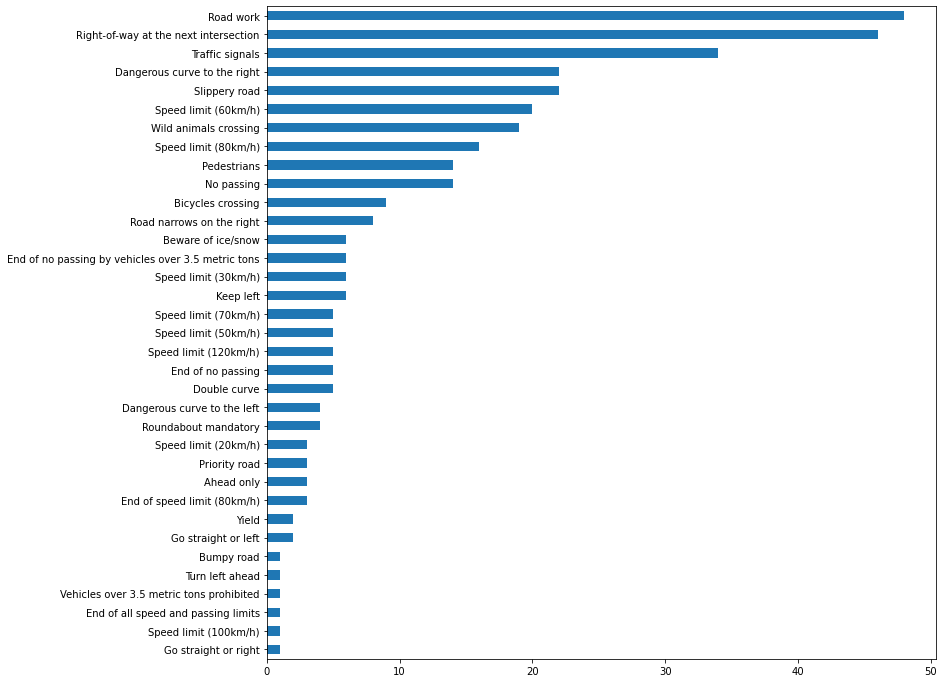

In [58]:
counts = pd.Series(countErrors).sort_values()
counts.plot(kind='barh', figsize=(12, 12))
plt.savefig('error.jpg')